## DATASET

In [77]:
# importing libs and dataset
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn import svm
import sklearn
import matplotlib
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)

df_original = pd.read_csv('dataset/online_shoppers_intention.csv')
df_original.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [2]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [3]:
# shape, null values and shape

shape = df_original.shape
nulls = df_original.isna().sum()
nuniq = df_original.nunique()


print(f'NULLS SUM : \n {nulls}')
print(f'NUNIQUE SUM : \n {nuniq}')
print(f'SHAPE : \n {shape}')

NULLS SUM : 
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64
NUNIQUE SUM : 
 Administrative               27
Administrative_Duration    3335
Informational                17
Informational_Duration     1258
ProductRelated              311
ProductRelated_Duration    9551
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region             

In [5]:

df = df_original.copy()

continuous = []
categorical = []

for c in df.columns[:-1]:
    if df.nunique()[c] >= 30:
        continuous.append(c)
    else:
        categorical.append(c)




## PLOTS

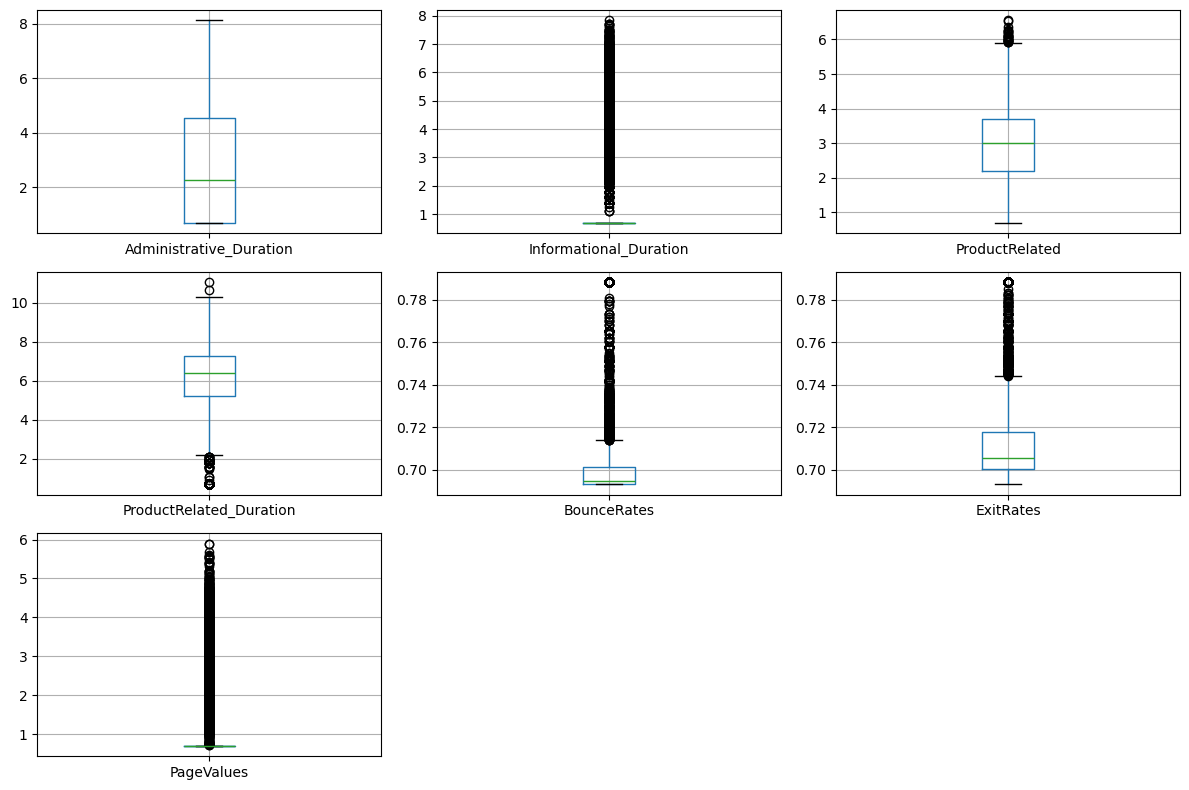

In [65]:
# continuous variables boxplot 
df[continuous] = np.log1p(1 + df[continuous])
# Plot das variáveis contínuas

# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i,col in enumerate(continuous):
    plt.subplot(3,3,i+1);
    df.boxplot(col);
    plt.tight_layout()


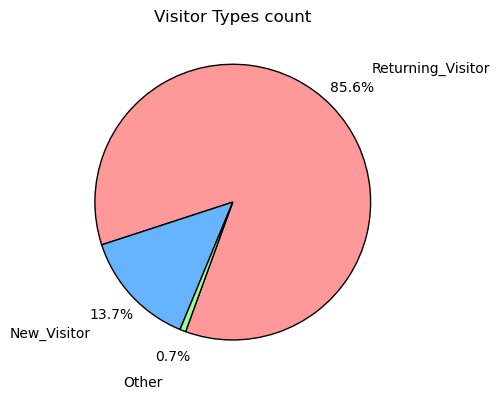

In [214]:
# pie plot Visitor Types count
visitor_counts = df['VisitorType'].value_counts()

# Definir rótulos e cores
labels = visitor_counts.index
colors = ['#ff9999','#66b3ff','#99ff99']  # Cores distintas para cada tipo

# Plotar gráfico de pizza
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(visitor_counts, labels=labels, autopct='%.1f%%', colors=colors, startangle=250,pctdistance=1.2, labeldistance=1.4, wedgeprops={'edgecolor': 'black'})

# Adicionar título1
plt.title("Visitor Types count", fontsize=12)

# Adicionar uma legenda
#plt.legend(title='Tipo de Visitante', title_fontsize='14', fontsize='12', loc='upper right', bbox_to_anchor=(1, 1))

# Ajustar layout para melhorar a exibição
plt.tight_layout()

# Exibir o gráfico
plt.show()

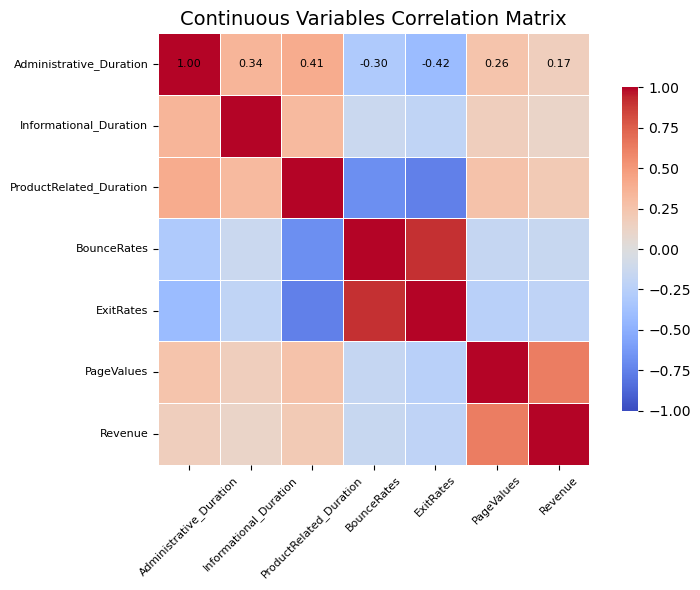

In [222]:
# correlation matrix
plt.figure(figsize=(8, 6))


corr = df[['Administrative_Duration',
           'Informational_Duration',  
           'ProductRelated_Duration',
           'BounceRates', 
           'ExitRates', 
           'PageValues',
           'Revenue']].corr()

# Criar o heatmap com ajustes
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmax=1.0, vmin=-1.0, square=True, 
            linewidths=0.5, cbar_kws={'shrink': .75},
            annot_kws={"size": 8, "color": 'black'},
            mask=corr.abs() < 0.1)  # Máscara para esconder correlações pequenas

# Adicionar título e rótulos
plt.title('Continuous Variables Correlation Matrix', fontsize=14)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)

plt.tight_layout()  # Ajusta o layout para não cortar os rótulos
plt.show()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64


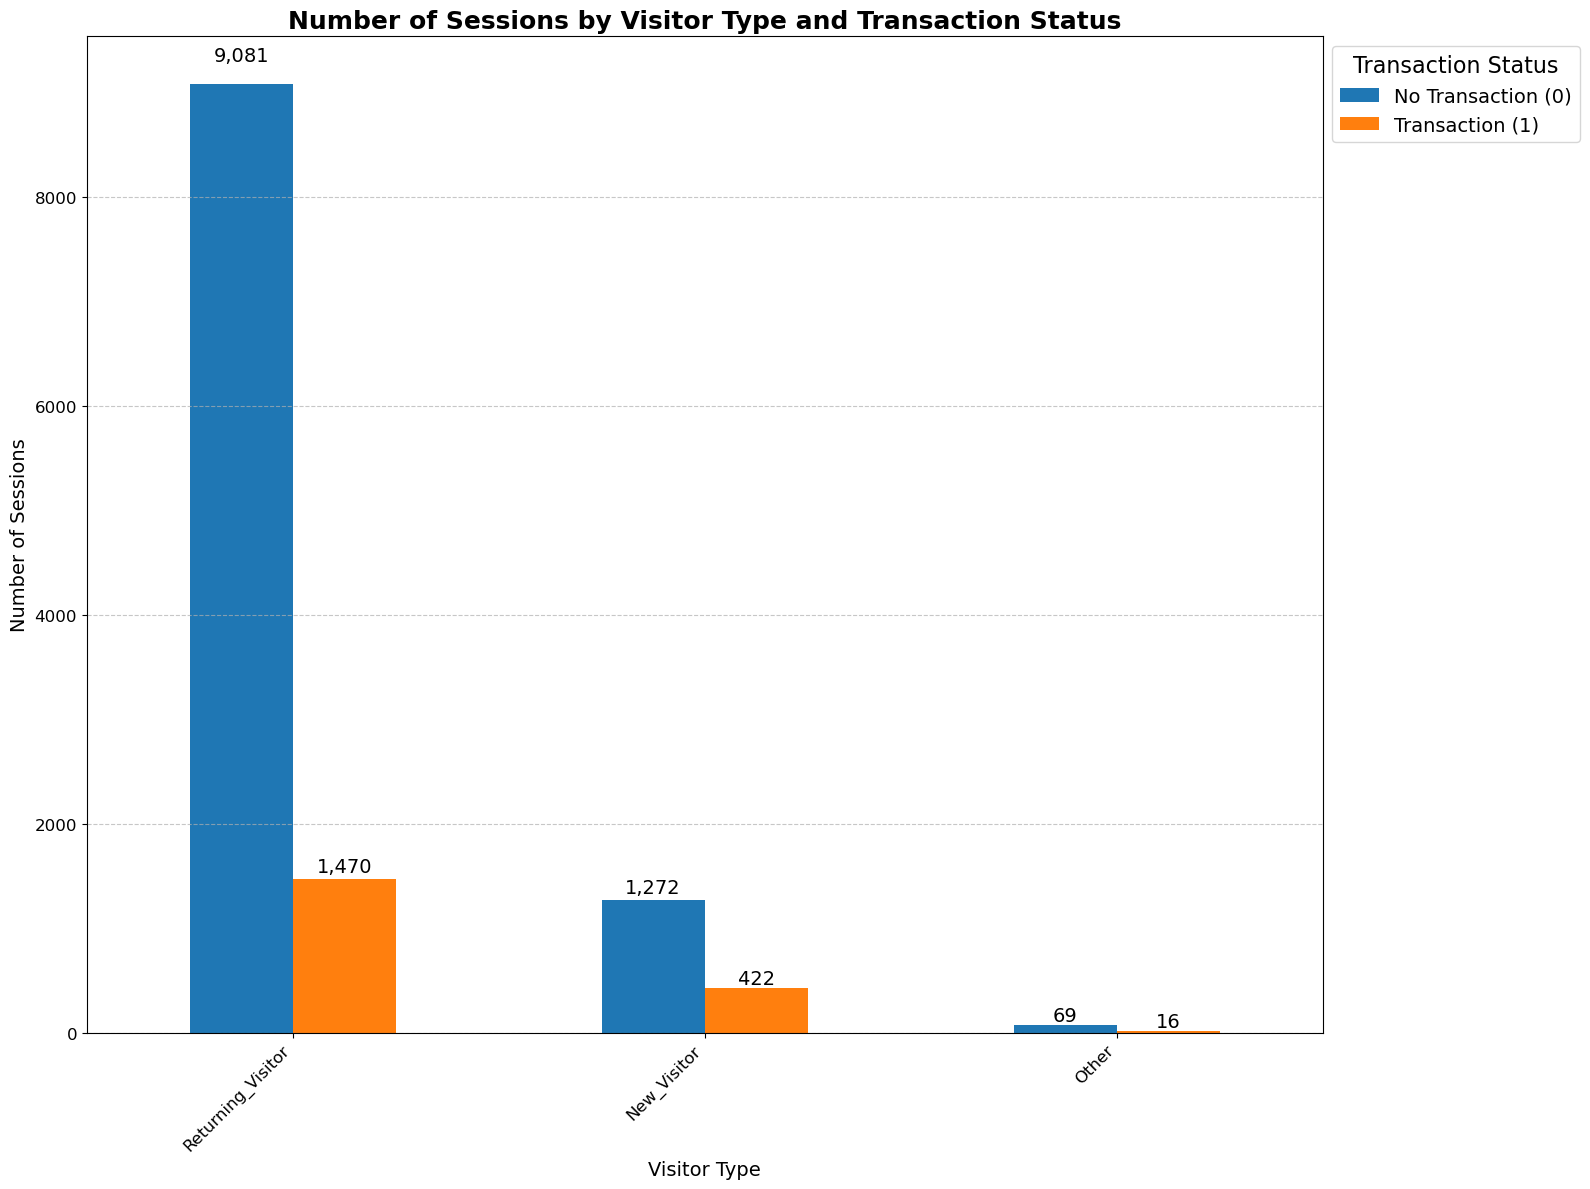

In [165]:
# visitortype and total of transactions
print(df['VisitorType'].value_counts())

# Filtrar o DataFrame para incluir apenas linhas onde VisitorType não é 'Other'
new_df = df[df['VisitorType'] != 'Other'][['VisitorType', 'Revenue']]


# Agrupar por VisitorType e Revenue para contar as ocorrências
revenue_visitor_df = df.groupby(['VisitorType', 'Revenue']).size().unstack(fill_value=0).reset_index()
revenue_visitor_df.columns = ['VisitorType', 'No Transaction (0)', 'Transaction (1)']  # Renomear colunas

# Ordenar o DataFrame pela soma total das sessões para cada VisitorType
revenue_visitor_df['Total Sessions'] = revenue_visitor_df['No Transaction (0)'] + revenue_visitor_df['Transaction (1)']
revenue_visitor_df = revenue_visitor_df.sort_values(by='Total Sessions', ascending=False).drop(columns='Total Sessions')

# Plotagem
fig, ax = plt.subplots(figsize=(16, 12))

# Plotar gráfico de barras empilhadas com uma paleta de cores mais acessível
colors = ['#1f77b4', '#ff7f0e']  # Cores para 'No Transaction' e 'Transaction'
revenue_visitor_df.plot(kind='bar', x='VisitorType', stacked=False, color=colors, ax=ax)

# Adicionar título e rótulos
plt.title('Number of Sessions by Visitor Type and Transaction Status', fontsize=18, fontweight='bold')
plt.xlabel('Visitor Type', fontsize=14)
plt.ylabel('Number of Sessions', fontsize=14)

# Adicionar rótulos de valor nas barras com anotações detalhadas
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02 * height, f'{height:,}', 
                ha='center', va='bottom', fontsize=14, color='black')

# Melhorar o estilo do gráfico
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotaciona os rótulos do eixo x para melhor leitura
plt.yticks(fontsize=12)  # Ajusta os rótulos do eixo y para consistência
plt.legend(title='Transaction Status', title_fontsize='16', fontsize='14', loc='upper left', bbox_to_anchor=(1, 1))  # Aumenta o tamanho da fonte da legenda e ajusta a localização
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adiciona uma grade horizontal

# Ajustar layout e margens do gráfico
plt.tight_layout()  # Ajusta automaticamente os parâmetros do gráfico para se ajustar à figura

# Exibir o gráfico
plt.show()

In [235]:
df['Weekend'] = df['Weekend'].astype(int)
weekend_df = df[['Weekend']].value_counts().reset_index()
weekend_df.columns = ['weekend', 'count']
weekend_df['%'] = df['Weekend'].value_counts(normalize=True).round(2)
weekend_df.plot(kind=)

,weekend,count,%
0,0,9462,0.77
1,1,2868,0.23


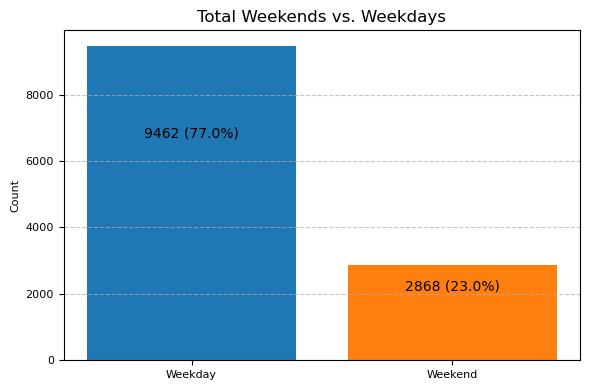

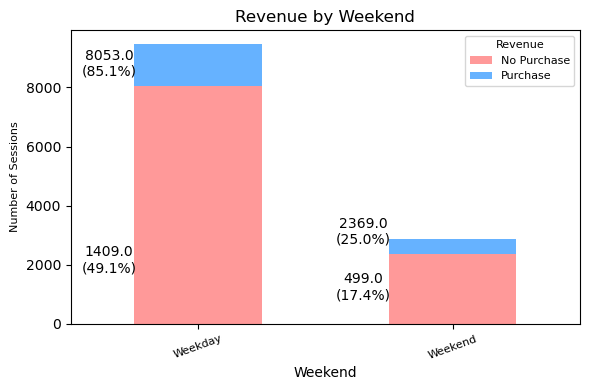

In [312]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que df é o seu DataFrame
df['Weekend'] = df['Weekend'].astype(int)

# Contar o número de ocorrências para cada valor de 'Weekend'
weekend_df = df[['Weekend']].value_counts().reset_index()
weekend_df.columns = ['Weekend', 'Count']

# Calcular porcentagem
weekend_df['%'] = df['Weekend'].value_counts(normalize=True).round(2).values

# Plotagem do gráfico de barras com contagem e porcentagem
fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(weekend_df['Weekend'].astype(str), weekend_df['Count'], color=['#1f77b4', '#ff7f0e'])

# Adicionar rótulos de porcentagem em cima das barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + -0.3 * height, 
            f'{height} ({weekend_df["%"].iloc[i]*100:.1f}%)', 
            ha='center', va='bottom', fontsize=10, color='black' )

# Adicionar título e rótulos
plt.title('Total Weekends vs. Weekdays', fontsize=12)
plt.ylabel('Count', fontsize=8)

# Ajustar estilo do gráfico
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adicionar grade horizontal

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

# Criar uma tabela cruzada para Weekend vs Revenue
crosstab = pd.crosstab(df['Weekend'], df['Revenue'])
crosstab.columns = ['No Purchase', 'Purchase']

# Plotar o gráfico de barras empilhadas
fig, ax = plt.subplots(figsize=(6, 4))

crosstab.plot(kind='bar', 
              stacked=True, 
              ax=ax, 
              color=['#FF9999', '#66B2FF'])  # Melhores escolhas de cores

# Adicionar rótulos e título
ax.set_ylabel('Number of Sessions', fontsize=8)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], fontsize=8, rotation=20)
ax.set_title('Revenue by Weekend', fontsize=12)

# Renomear as categorias de receita para a legenda
plt.legend(title='Revenue', labels=['No Purchase', 'Purchase'], fontsize=8, title_fontsize=8)

# Adicionar rótulos de dados com porcentagens
for i, patch in enumerate(ax.patches):
    height = patch.get_height()
    if height > 0:  # Somente anotar barras com altura > 0
        total_sessions = crosstab.iloc[i // 2].sum()  # Total de sessões para o valor de Weekend
        percentage = height / total_sessions * 100
        ax.annotate(f'{height}\n({percentage:.1f}%)', 
                    xy=(patch.get_x() + patch.get_width() / -5, height), 
                    xytext=(0, 5), 
                    textcoords='offset points', 
                    ha='center', 
                    va='bottom', 
                    fontsize=10)

# Mostrar o gráfico
plt.tight_layout()  # Ajustar layout para evitar cortes
plt.show()


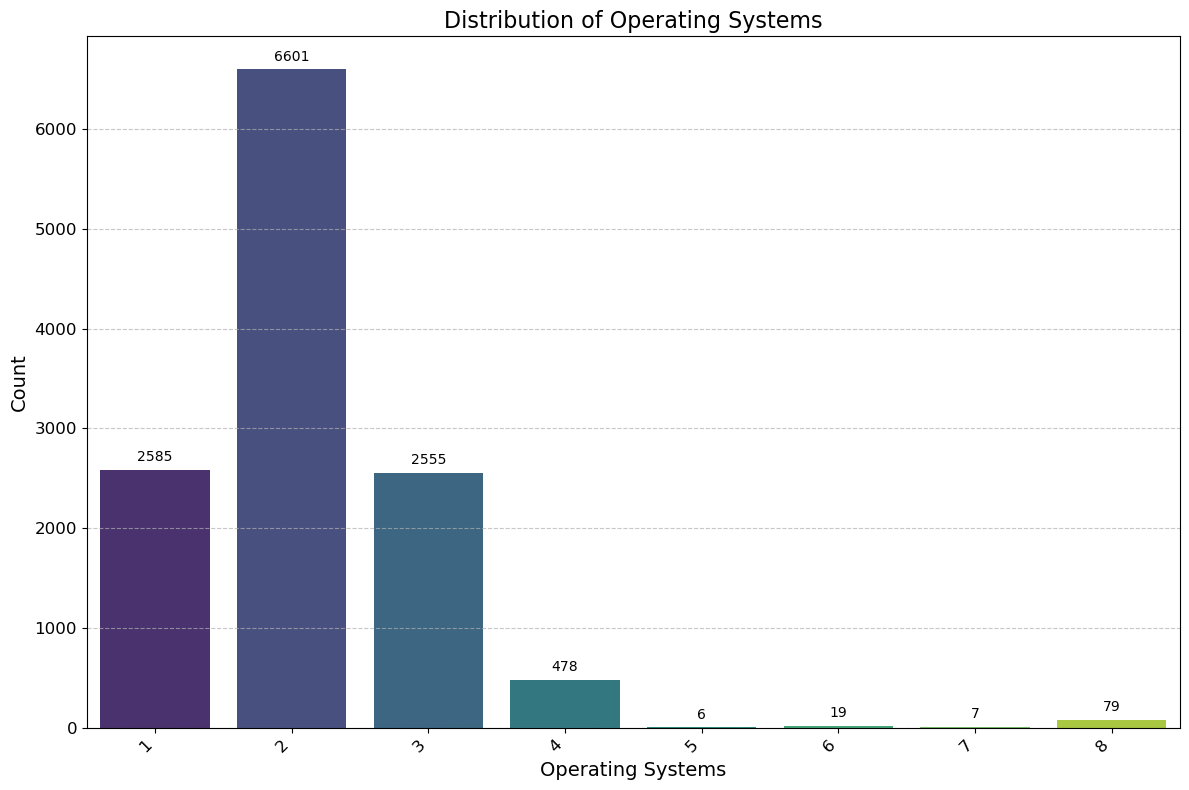

In [331]:
# Sort the DataFrame by 'count' in ascending order
os_df_sorted = os_df.sort_values(by='count', ascending=True)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='OperatingSystems', y='count', data=os_df_sorted, palette='viridis')

# Improve aesthetics
plt.xlabel('Operating Systems', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Operating Systems', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability

# Add value labels on top of bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points',
                     fontsize=10)

# Display the plot
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

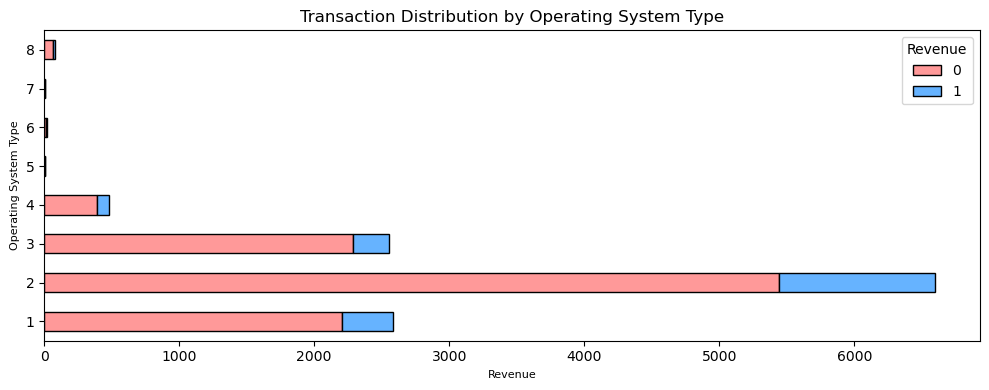

In [367]:
contingency_table = pd.crosstab(df['OperatingSystems'], df['Revenue'])

# Create the horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(10, 4))
contingency_table.plot(kind='barh', 
                      stacked=True, 
                      color=['#ff9999', '#66b3ff'],
                      edgecolor='black', 
                      ax=ax)

# Add title and labels
ax.set_title('Transaction Distribution by Operating System Type', fontsize=12)
ax.set_xlabel('Revenue', fontsize=8)
ax.set_ylabel('Operating System Type', fontsize=8)



# Display the plot
plt.tight_layout()
plt.show()

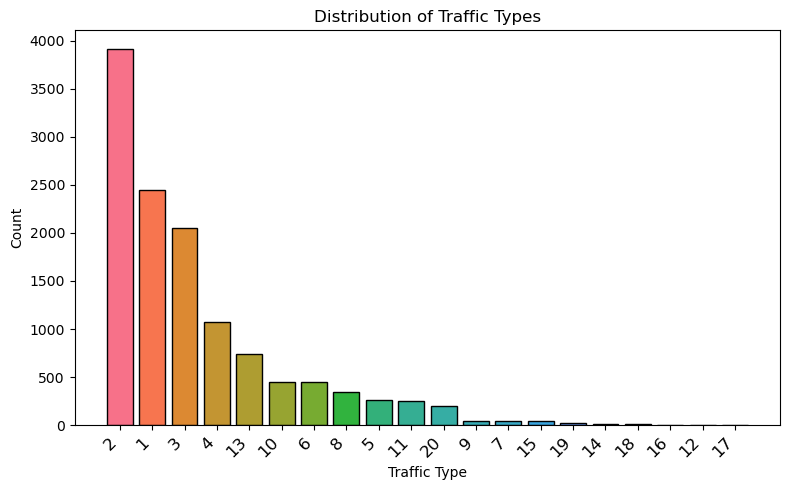

In [391]:

# Assuming df is your DataFrame and you have already created TrafficType_df
TrafficType_df = df[['TrafficType']].value_counts().reset_index()
TrafficType_df.columns = ['TrafficType', 'count']

# Choose a color palette from Seaborn
palette = sns.color_palette("husl", len(TrafficType_df))  # You can choose from palettes like 'husl', 'pastel', 'dark', etc.

# Create the bar plot with the Seaborn palette
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(TrafficType_df['TrafficType'].astype(str), TrafficType_df['count'], color=palette, edgecolor='black')

# Add title and labels
ax.set_title('Distribution of Traffic Types', fontsize=12)
ax.set_xlabel('Traffic Type', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_xticklabels(TrafficType_df['TrafficType'].astype(str), rotation=45, ha='right', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

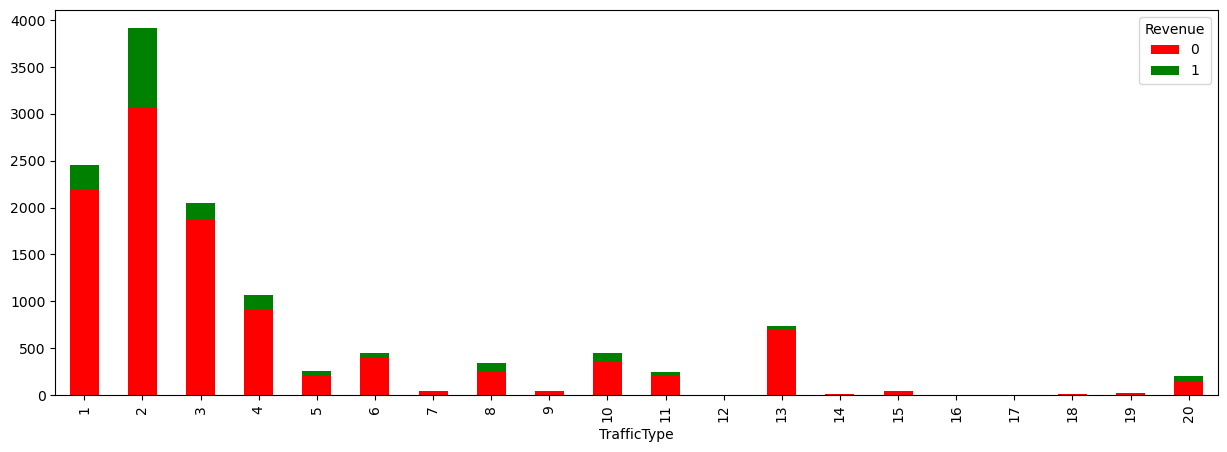

In [392]:
# Stacked Bar Tipos de Tráfego x Revenue
pd.crosstab(df['TrafficType'], df['Revenue']).plot(kind = 'bar', 
                                                   stacked = True, 
                                                   figsize = (15, 5), 
                                                   color = ['red', 'green'])
plt.show()

## ML MODEL

In [78]:
# maps

visitor_map = {'Returning_Visitor':1,'New_Visitor':2,'Other':3}
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}


df_original['Month'] = df_original['Month'].replace(month_mapping).astype(int)
df_original['VisitorType'] = df_original['VisitorType'].replace(visitor_map)
df_original[['Weekend', 'Revenue']] = df_original[['Weekend', 'Revenue']].astype(int)

In [79]:

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

# Seed para reproduzir o mesmo resultado
seed = 100

# Separa X e y
X = df_original.iloc[:, 0:17]  
y = df_original.iloc[:, 17] 

# Cria o balanceador SMOTE
smote_bal = SMOTE(random_state = seed)

# Aplica o balanceador
X_res, y_res = smote_bal.fit_resample(X, y)

In [80]:
print(y_res.value_counts())
print(y_res.shape)
print(X_res.shape)

0    10422
1    10422
Name: Revenue, dtype: int64
(20844,)
(20844, 17)


In [81]:
X = X_res.head(1000)
y = y_res.head(1000)

# Divisão em Dados de Treino e Teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [82]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Modelo SVM
### Modelo Base com Kernel Linear

In [83]:
modelo_v1 = svm.SVC(kernel = 'linear')

In [ ]:
# Treinamento
start = time.time()
modelo_v1.fit(X_treino, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

In [ ]:
# Treinamento
start = time.time()
modelo_v1.fit(X_treino, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

In [ ]:
previsoes_v1 = modelo_v1.predict(X_teste)

In [ ]:
# Dicionário de métricas e metadados
SVM_dict_v1 = {'Modelo':'SVM',
               'Versão':'1',
               'Kernel':'Linear',
               'Precision':precision_score(previsoes_v1, y_teste),
               'Recall':recall_score(previsoes_v1, y_teste),
               'F1 Score':f1_score(previsoes_v1, y_teste),
               'Acurácia':accuracy_score(previsoes_v1, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v1)}

In [ ]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v1

In [ ]:
# Agora sim, a forma ideal de aplicar a padronização em treino e teste
# Padronização
sc = StandardScaler()
X_treino_scaled = sc.fit_transform(X_treino)
X_teste_scaled = sc.transform(X_teste)